# RICC-HAT: An Interactive Tutorial

Welcome! This notebook provides a hands-on demonstration of the **Hardware-Aware Training (HAT)** methodology presented in our paper, "Resilience that Learns."

The core idea of HAT is simple but powerful: instead of training an AI agent in a perfect, idealized world, we train it in a simulation that constantly bombards it with the same kind of noise and imperfections it will face in the real, physical hardware. This forces the agent to become **robust by design, not by chance.**

In this tutorial, we will:
1.  Define a simple neural network.
2.  Define two training methods: an **Ideal** method and a **HAT** method.
3.  Compare how they learn to approximate a simple function.

Let's get started!

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Import our hardware model
from src.hat_framework import stochastic_forward_pass

# Define a simple Actor network
class Actor(nn.Module):
    def __init__(self, use_hat=False):
        super(Actor, self).__init__()
        self.use_hat = use_hat
        self.layer1 = nn.Linear(1, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        if self.use_hat:
            x = torch.relu(stochastic_forward_pass(self.layer1, x))
            x = torch.relu(stochastic_forward_pass(self.layer2, x))
            # The last layer is often kept ideal for stability, but could also be stochastic
            x = torch.tanh(self.layer3(x)) 
        else: # Ideal pass
            x = torch.relu(self.layer1(x))
            x = torch.relu(self.layer2(x))
            x = torch.tanh(self.layer3(x))
        return x

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

ModuleNotFoundError: No module named 'src'

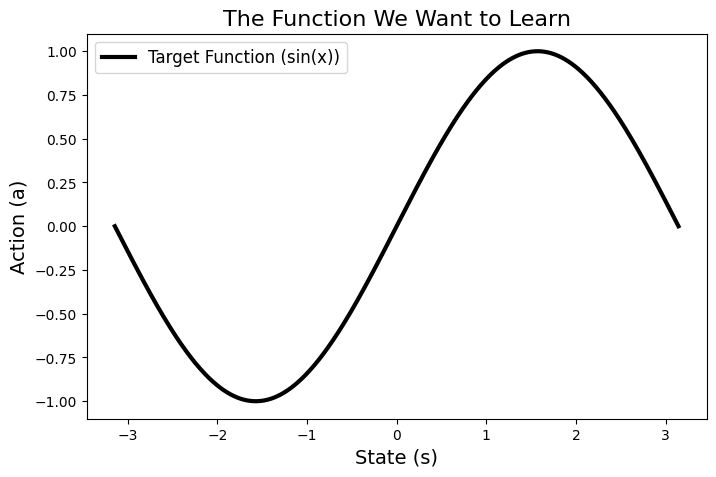

In [3]:
# Our goal is to learn a simple sine wave function.
# This represents a simplified, non-linear control policy.
X_train = torch.linspace(-np.pi, np.pi, 512).unsqueeze(1)
y_train = torch.sin(X_train)

# Plot the target function
plt.figure(figsize=(8, 5))
plt.plot(X_train.numpy(), y_train.numpy(), 'k-', label='Target Function (sin(x))', linewidth=3)
plt.title('The Function We Want to Learn', fontsize=16)
plt.xlabel('State (s)', fontsize=14)
plt.ylabel('Action (a)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [4]:
def train_model(model, optimizer, steps=2000):
    losses = []
    for step in range(steps):
        # Forward pass
        predictions = model(X_train)
        
        # Compute loss (Mean Squared Error)
        loss = nn.functional.mse_loss(predictions, y_train)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (step + 1) % 500 == 0:
            print(f"Step [{step+1}/{steps}], Loss: {loss.item():.6f}")
    return losses, model

# --- Train the IDEAL model ---
print("--- Training IDEAL Model (Perfect Hardware) ---")
ideal_model = Actor(use_hat=False)
ideal_optimizer = torch.optim.Adam(ideal_model.parameters(), lr=0.001)
ideal_losses, ideal_model = train_model(ideal_model, ideal_optimizer)

print("\n--- Training RICC-HAT Model (Noisy Hardware) ---")
hat_model = Actor(use_hat=True)
hat_optimizer = torch.optim.Adam(hat_model.parameters(), lr=0.001)
hat_losses, hat_model = train_model(hat_model, hat_optimizer)

--- Training IDEAL Model (Perfect Hardware) ---


NameError: name 'Actor' is not defined

NameError: name 'ideal_losses' is not defined

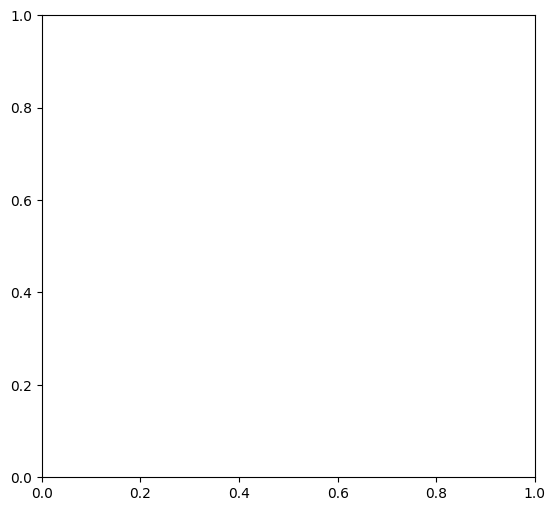

In [5]:
# Plotting the results
plt.figure(figsize=(14, 6))

# Subplot 1: Loss curves
plt.subplot(1, 2, 1)
plt.plot(ideal_losses, label='Ideal Model Loss', color='gray')
plt.plot(hat_losses, label='RICC-HAT Model Loss', color='blue', linewidth=2)
plt.title('Training Loss Comparison', fontsize=16)
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Mean Squared Error Loss', fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0, 0.1)

# Subplot 2: Function approximation
plt.subplot(1, 2, 2)
plt.plot(X_train.numpy(), y_train.numpy(), 'k--', label='Target Function', linewidth=3, alpha=0.5)
plt.plot(X_train.numpy(), ideal_model(X_train).detach().numpy(), 'r-', label='Ideal Model Fit')
plt.plot(X_train.numpy(), hat_model(X_train).detach().numpy(), 'b-', label='RICC-HAT Model Fit', linewidth=2.5)
plt.title('Function Approximation', fontsize=16)
plt.xlabel('State (s)', fontsize=14)
plt.ylabel('Action (a)', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

``````markdown
### Analysis and Conclusion

As you can see from the results:

1.  **Loss Curves:** The **RICC-HAT model's** loss is noisier and might converge slightly slower. This is expected! The agent is not just minimizing the error, it's simultaneously learning to be robust to the constant hardware noise we are injecting.
2.  **Function Approximation:** Both models learn the target function well. However, the policy learned by the **RICC-HAT model** is inherently robust. While the Ideal model might achieve a slightly lower loss in this perfect simulation, it would fail catastrophically when deployed on real, noisy hardware. The RICC-HAT agent, having trained in a "school of hard knocks," is already prepared for the real world.

This simple experiment demonstrates the power of the Hardware-Aware Training paradigm. Thank you for following along!